In [2]:
from modules import *

from skcosmo.preprocessing import StandardFlexibleScaler, KernelNormalizer
from skcosmo.decomposition import KPCovR
# from skcosmo.sample_selection import FPS
from sklearn.decomposition import KernelPCA
from sklearn.manifold import LocallyLinearEmbedding
from sklearn.linear_model import LinearRegression as LR
from sklearn.linear_model import Ridge as Ridge
from sklearn.metrics.pairwise import linear_kernel, rbf_kernel
from sklearn.kernel_ridge import KernelRidge
from functools import partial

In [3]:
#dataset load
len_dataset=79855
load_profile('Elena')
qb = QueryBuilder()
qb.append(orm.StructureData)

In [5]:
select=1000
# n=[]
qb_red=random.sample(qb.all(), select)


In [6]:
frames_ase=[]
for [structure_data] in qb_red:
    frame=structure_data.get_ase()
#     n=frame.get_atomic_numbers()
#     print(n)
#     form=frame.get_chemical_formula(mode='metal')
#     print(form)
    frame.wrap(eps=1e-11)
    frames_ase.append(frame)
#     number_electrons=sum(frame.numbers)
#     n.append(number_electrons)  

In [7]:
n_FPS=50
# frames_ase_tot=[]
Xsparse_tot=[]

soap = SOAP(soap_type='PowerSpectrum',
           interaction_cutoff=3.5,
           max_radial=5,
           max_angular=5,
           gaussian_sigma_type='Constant',
           gaussian_sigma_constant=0.4,
           cutoff_smooth_width=0.5, 
           normalize=False)
# start=0
for i in range(0, 300, 50):
#     print(i)
#     print(len(frames_ase[i:i+50]))
# #     qb_red=qb.all()[start:i]
# #     print(len(qb_red))
# #     frames_ase=[]
# #     for [structure_data] in qb_red:
# #         frame=structure_data.get_ase()
# #         frame.wrap(eps=1e-10)
# #         frames_ase.append(frame)

    soap_rep= soap.transform(frames_ase[i:i+50])
    Xsparse = soap_rep.get_features(soap)
#     frames_ase_tot.append(frames_ase)
    X_raw_pd=pd.DataFrame(Xsparse)
    X_raw_pd_drop=X_raw_pd.loc[:, (X_raw_pd != 0).any(axis=0)]
    X_raw_red = X_raw_pd_drop.to_numpy()
    print(str(Xsparse.shape[1]-X_raw_red.shape[1])+ " columns dropped because they are all 0s.")
    Xsparse=X_raw_red
    col_idxs, col_dist = FPS(Xsparse.T, n_FPS)
    Xsparse = Xsparse[:, col_idxs]
    Xsparse_tot.append(Xsparse)
#     start+=100


# for i in range(start, 100, 50):
#     soap_rep1= soap1.transform(frames_ase[51:101])
#     Xsparse1 = soap_rep1.get_features(soap1)
#     X_raw_pd1=pd.DataFrame(Xsparse1)
#     X_raw_pd_drop1=X_raw_pd1.loc[:, (X_raw_pd1 != 0).any(axis=0)]
#     X_raw_red1 = X_raw_pd_drop1.to_numpy()
#     Xsparse1=X_raw_red1
#     col_idxs, col_dist = FPS(Xsparse1.T, n_FPS)
#     Xsparse1 = Xsparse1[:, col_idxs]



# soap2 = SOAP(soap_type='PowerSpectrum',
#            interaction_cutoff=3.5,
#            max_radial=5,
#            max_angular=5,
#            gaussian_sigma_type='Constant',
#            gaussian_sigma_constant=0.4,
#            cutoff_smooth_width=0.5, 
#            normalize=False)

# soap_rep2= soap2.transform(frames_ase[101:151])
# Xsparse2 = soap_rep2.get_features(soap2)

# X_raw_pd2=pd.DataFrame(Xsparse2)
# X_raw_pd_drop2=X_raw_pd2.loc[:, (X_raw_pd2 != 0).any(axis=0)]
# X_raw_red2 = X_raw_pd_drop2.to_numpy()

# # print(str(Xsparse.shape[1]-X_raw_red.shape[1])+ " columns dropped because they are all 0s.")
# Xsparse2=X_raw_red2

# col_idxs, col_dist = FPS(Xsparse2.T, n_FPS)
# Xsparse2= Xsparse2[:, col_idxs]


850 columns dropped because they are all 0s.
1075 columns dropped because they are all 0s.
725 columns dropped because they are all 0s.
700 columns dropped because they are all 0s.
1250 columns dropped because they are all 0s.
550 columns dropped because they are all 0s.


In [10]:
l=np.concatenate(frames_ase[:150])
len(l),l.shape 
Y=np.zeros((len(l), 1))

natoms_list=[]
start=0
for frame in frames_ase[:150]:
    natoms=(len(frame))
#     Y[start:int(start+natoms), 0] = int(natoms)
    if natoms%4==0:
        Y[start:int(start+natoms)] = int(2)
    else:
        Y[start:int(start+natoms)] = int(1)
    start=start+natoms
Y.shape

(5978, 1)

In [9]:
Xrest=np.concatenate((Xsparse_tot[0], Xsparse_tot[1], Xsparse_tot[2]))
Xrest.shape

(5978, 50)

In [1]:
Xrest=np.concatenate((Xsparse_tot[0], Xsparse_tot[1], Xsparse_tot[2]))


NameError: name 'np' is not defined

In [29]:
# Change this cell to change the kernel function throughout
kernel_params = {"kernel": "rbf", "gamma": 0.5}
kernel_func = partial(rbf_kernel, gamma=0.5)
kernel_type = "gaussian"

In [30]:
Xsparse=Xsparse_tot[0]
print(Xsparse_tot[0].shape)
x_scaler = StandardFlexibleScaler(column_wise=False).fit(Xsparse)
Xsparse = x_scaler.transform(Xsparse)

x_scaler1 = StandardFlexibleScaler(column_wise=False).fit(Xrest)
Xrest = x_scaler1.transform(Xrest)

Kmm = kernel_func(Xsparse, Xsparse)
Knm = kernel_func(Xsparse, Xrest)


Knm.shape, Kmm.shape



(1940, 50)


((1940, 5978), (1940, 1940))

In [31]:
Ktot=Knm.T@Kmm@Knm
Ktot.shape

(5978, 5978)

In [32]:
K_center = np.mean(Knm, axis=0)
K_center
Knm -= K_center
Knm.shape, Kmm.shape


((1940, 5978), (1940, 1940))

In [33]:
K_scale = Knm.T @ np.linalg.pinv(Kmm, rcond=1.0E-12) @ Knm
print(K_scale)
K_scale = np.sqrt(np.trace(K_scale) / Knm.shape[0])
print(K_scale)


[[ 5.49639479  5.49639479  5.96541121 ...,  6.92199673  6.92199673
   6.92199673]
 [ 5.49639479  5.49639479  5.96541122 ...,  6.92199674  6.92199674
   6.92199674]
 [ 5.96541121  5.96541121  6.64126905 ...,  7.77996081  7.77996081
   7.77996081]
 ..., 
 [ 6.92199671  6.92199671  7.7799608  ...,  9.69110402  9.69110402
   9.69110402]
 [ 6.92199671  6.92199671  7.7799608  ...,  9.69110402  9.69110402
   9.69110402]
 [ 6.92199673  6.92199673  7.77996083 ...,  9.69110405  9.69110405
   9.69110405]]
4.16735541056


In [34]:
n_active=51

Knm /= K_scale
print(Knm)
vmm, Umm = np.linalg.eigh(Kmm)

# Umm/vmm are already sorted, but in *increasing* order, so reverse them
Umm = np.flip(Umm, axis=1)
vmm = np.flip(vmm, axis=0)

Umm = Umm[:, vmm > 0]
vmm = vmm[vmm > 0]

Phi = (
    Knm.T
    @ Umm[:, : n_active - 1]
    @ np.diagflat(1.0 / np.sqrt(vmm[0 : n_active - 1]))
)

Phi, Phi.shape

[[ 0.12653552  0.12653552  0.09770287 ..., -0.00044695 -0.00044695
  -0.00044695]
 [ 0.12653552  0.12653552  0.09770287 ..., -0.00044695 -0.00044695
  -0.00044695]
 [ 0.10539828  0.10539828  0.11456989 ...,  0.0255076   0.0255076
   0.0255076 ]
 ..., 
 [ 0.00467933  0.00467933  0.01558831 ...,  0.03149119  0.03149119
   0.03149119]
 [ 0.00467933  0.00467933  0.01558831 ...,  0.03149119  0.03149119
   0.03149119]
 [ 0.00467933  0.00467933  0.01558831 ...,  0.03149119  0.03149119
   0.03149119]]


(array([[-0.01025219, -0.00660162,  0.05975335, ...,  0.04382603,
          0.01003717, -0.00278071],
        [-0.01025219, -0.00660162,  0.05975335, ...,  0.04382603,
          0.01003717, -0.00278071],
        [-0.01229918, -0.03236742,  0.07145008, ...,  0.02445655,
          0.01829867,  0.01147231],
        ..., 
        [-0.01593771, -0.05998922,  0.09176175, ...,  0.02137841,
          0.01890811,  0.01962999],
        [-0.01593771, -0.05998922,  0.09176175, ...,  0.02137841,
          0.01890811,  0.01962999],
        [-0.01593771, -0.05998922,  0.09176175, ...,  0.02137841,
          0.01890811,  0.01962999]]),
 (5978, 50))

In [35]:

# Xsparse_FPS = (Xsparse_FPS - X_center) / X_scale

x_scaler = StandardFlexibleScaler(column_wise=False).fit(Xsparse)

# Center total dataset
Xsparse = x_scaler.transform(Xsparse)

In [36]:
C = np.dot(Phi.T, Phi)
print(C, C.shape)
v_C, U_C = np.linalg.eigh(C)

# U_C/v_C are already sorted, but in *increasing* order, so reverse them
U_C = np.flip(U_C, axis=1)
v_C = np.flip(v_C, axis=0)

U_C = U_C[:, v_C > 0]
v_C = v_C[v_C > 0]
n_PC=2

PKT = (
    Umm[:, : n_active - 1]
    @ np.diagflat(1.0 / np.sqrt(vmm[0 : n_active - 1]))
    @ U_C[:, :n_PC]
)
print(PKT, PKT.shape)





[[  0.77732647   0.24393803  -4.29608521 ...,  -1.05229589  -1.06573986
   -0.95216723]
 [  0.24393803  21.92999717  -2.59609604 ...,  -0.48817949  -0.05515386
   -1.09638746]
 [ -4.29608521  -2.59609604  27.97317412 ...,   5.70060643   5.77813802
    5.09508919]
 ..., 
 [ -1.05229589  -0.48817949   5.70060643 ...,   1.87651026   1.57837867
    1.22501138]
 [ -1.06573986  -0.05515386   5.77813802 ...,   1.57837867   1.81452447
    1.20395846]
 [ -0.95216723  -1.09638746   5.09508919 ...,   1.22501138   1.20395846
    1.6980521 ]] (50, 50)
[[-0.00087808  0.00539835]
 [-0.00087808  0.00539835]
 [ 0.00339607  0.0019642 ]
 ..., 
 [-0.0002898  -0.00080869]
 [-0.0002898  -0.00080869]
 [-0.0002898  -0.00080869]] (1940, 2)


In [37]:
T_tot = Knm.T @ PKT

print(T_tot, T_tot.shape)

[[-0.32066573  0.01215057]
 [-0.32066573  0.01215057]
 [-0.36443953 -0.01649508]
 ..., 
 [-0.46608981 -0.05238067]
 [-0.46608981 -0.05238067]
 [-0.46608981 -0.05238067]] (5978, 2)


<AxesSubplot:title={'center':'Sparse KPCA on 1940 Environments'}, xlabel='$PC_1$', ylabel='$PC_2$'>

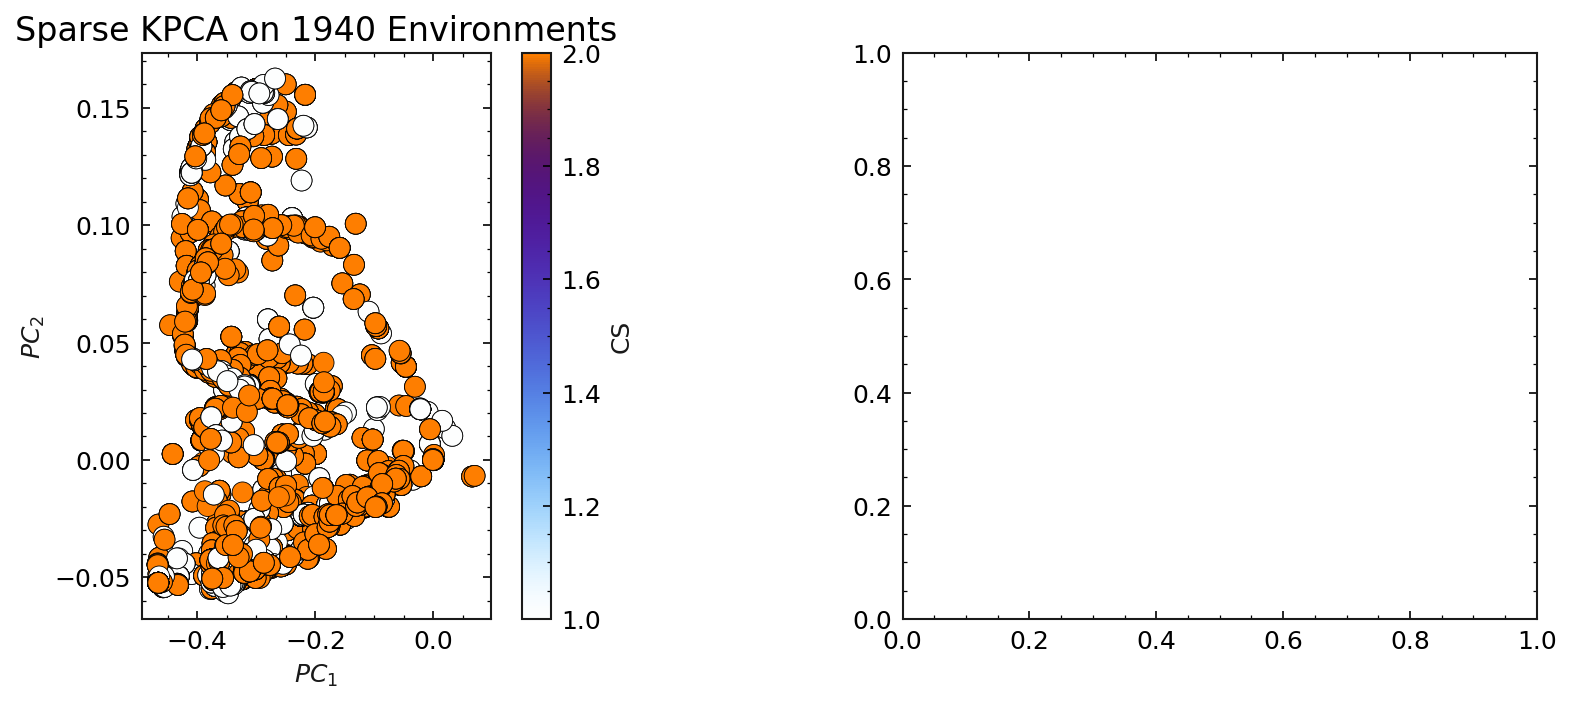

In [38]:
fig, axes = plt.subplots(1, 2, figsize=dbl_fig)

plot_projection(
    Y,
    T_tot,
    fig=fig,
    ax=axes[0],
    title="Sparse KPCA on {} Environments".format(Kmm.shape[0]),
    **cmaps
)

(5978, 2) (1940, 2) (5978, 1)


ValueError: 'c' argument has 5978 elements, which is inconsistent with 'x' and 'y' with size 1940.

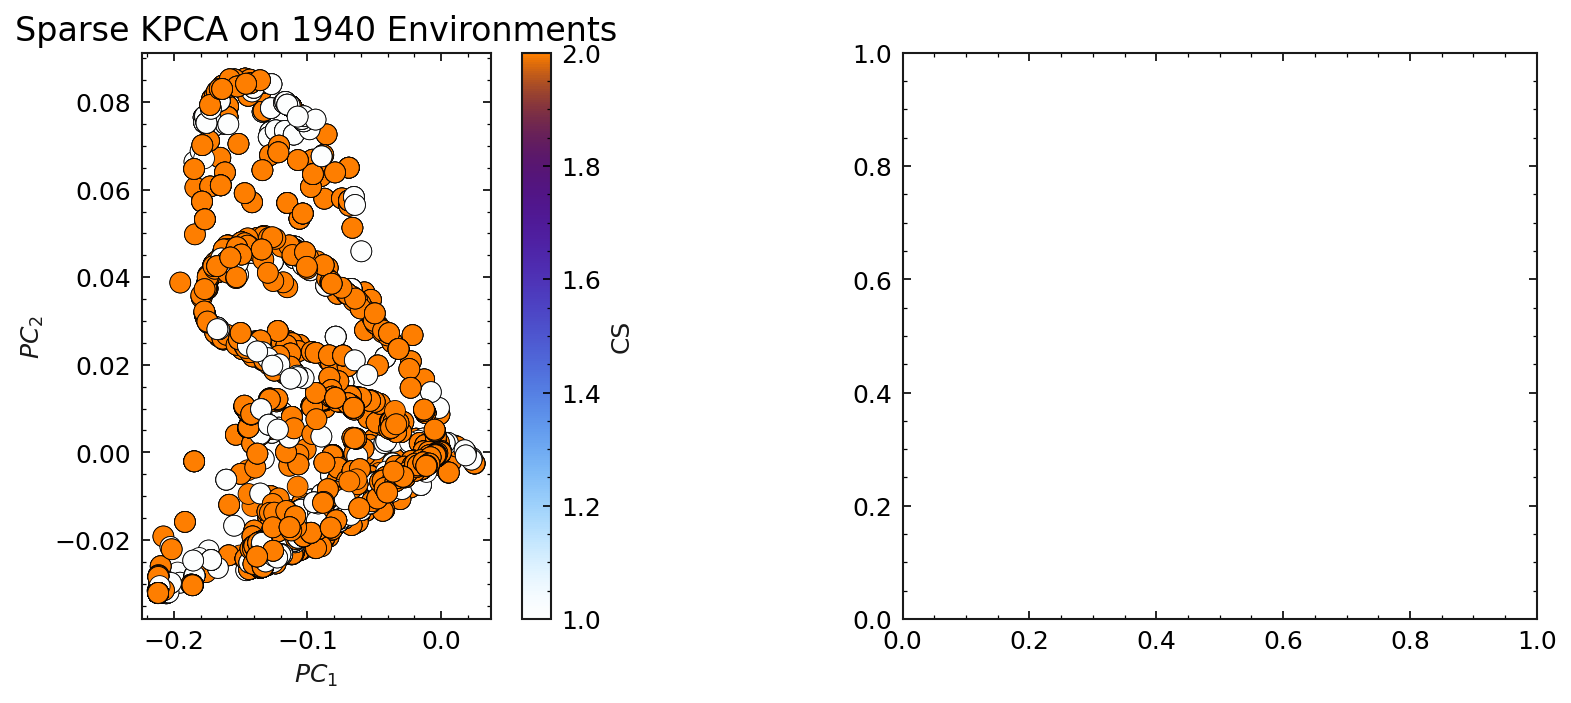

In [28]:
fig, axes = plt.subplots(1, 2, figsize=dbl_fig)

ref_kpca = KernelPCA(
    n_components=n_PC, kernel="rbf", gamma=1.0, fit_inverse_transform=True
)
ref_kpca.fit(Xsparse)
T_kpca = ref_kpca.transform(Xsparse)
printT_kpca.shape
print(T_tot.shape, T_kpca.shape, Y.shape)
plot_projection(
    Y,
    check_mirrors(T_tot, T_kpca),
    fig=fig,
    ax=axes[0],
    title="Sparse KPCA on {} Environments".format(Kmm.shape[0]),
    **cmaps
)
# plot_projection(
#     Y,
#     T_kpca,
#     fig=fig,
#     ax=axes[1],
#     title="KPCA on {} Environments".format(Xsparse.shape[0]),
#     **cmaps
# )

fig.subplots_adjust(wspace=0.4)



In [28]:
X=np.copy(Xsparse_FPS)

n_train = int(len(Y)/2)
n_test = len(Y)-n_train
r_train = np.asarray(range(len(Y)))
# i_train, i_test = train_test_split(r_train, train_size=n_train, shuffle=True)
i_test = list(sorted(r_train[n_train:]))
i_train = list(sorted(r_train[:n_train]))

X_train = X[i_train]
Y_train = Y[i_train]
X_test = X[i_test]
Y_test = Y[i_test]

In [29]:
x_scaler = StandardFlexibleScaler(column_wise=False).fit(X_train)
y_scaler = StandardFlexibleScaler(column_wise=True).fit(Y_train)

# Center total dataset
X = x_scaler.transform(X)
Y = y_scaler.transform(Y)

# Center training data
X_train = x_scaler.transform(X_train)
Y_train = y_scaler.transform(Y_train)

# Center training data
X_test = x_scaler.transform(X_test)
Y_test = y_scaler.transform(Y_test)

In [34]:
# K_train_raw = kernel_func(X_train, X_train)
# k_centerer = KernelNormalizer()
# K_train = k_centerer.fit_transform(K_train_raw)
# K_scale = k_centerer.scale_
# K_test = kernel_func(X_test, X_train)
# K_test = k_centerer.transform(K_test)

K_train = gaussian_kernel(X_train, X_train)
K_test = gaussian_kernel(X_test, X_train)

k_scaler = KernelNormalizer().fit(K_train)

K_train = k_scaler.transform(K_train)
K_test = k_scaler.transform(K_test)

# X_train = X_train * X_scale + X_center
# X_test = X_test * X_scale + X_center

NameError: name 'X_scale' is not defined

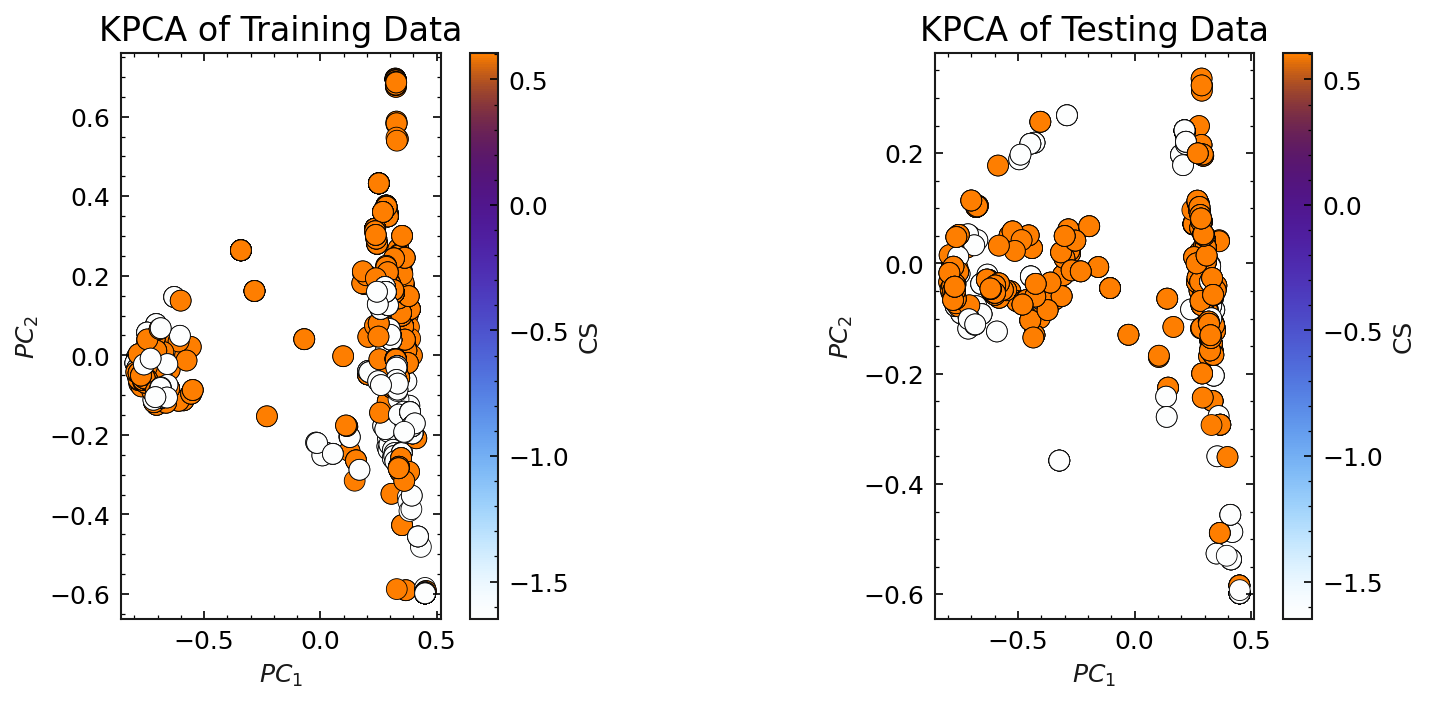

In [31]:
v_K, U_K = np.linalg.eigh(K_train)

# U_K/v_K are already sorted, but in *increasing* order, so reverse them
U_K = np.flip(U_K, axis=1)
v_K = np.flip(v_K, axis=0)

U_K = U_K[:, v_K > 0]
v_K = v_K[v_K > 0]

n_PC = 2
PKT = U_K[:, :n_PC] @ np.diagflat(1.0 / np.sqrt(v_K[0:n_PC]))
T_KPCA_train = K_train @ PKT
T_KPCA_test = K_test @ PKT
fig, axes = plt.subplots(1, 2, figsize=dbl_fig)
plot_projection(
    Y_train, T_KPCA_train, fig=fig, ax=axes[0], title="KPCA of Training Data", **cmaps
)
plot_projection(
    Y_test, T_KPCA_test, fig=fig, ax=axes[1], title="KPCA of Testing Data", **cmaps
)
fig.subplots_adjust(wspace=0.4)

<AxesSubplot:title={'center':'KPCovR'}, xlabel='$PC_1$', ylabel='$PC_2$'>

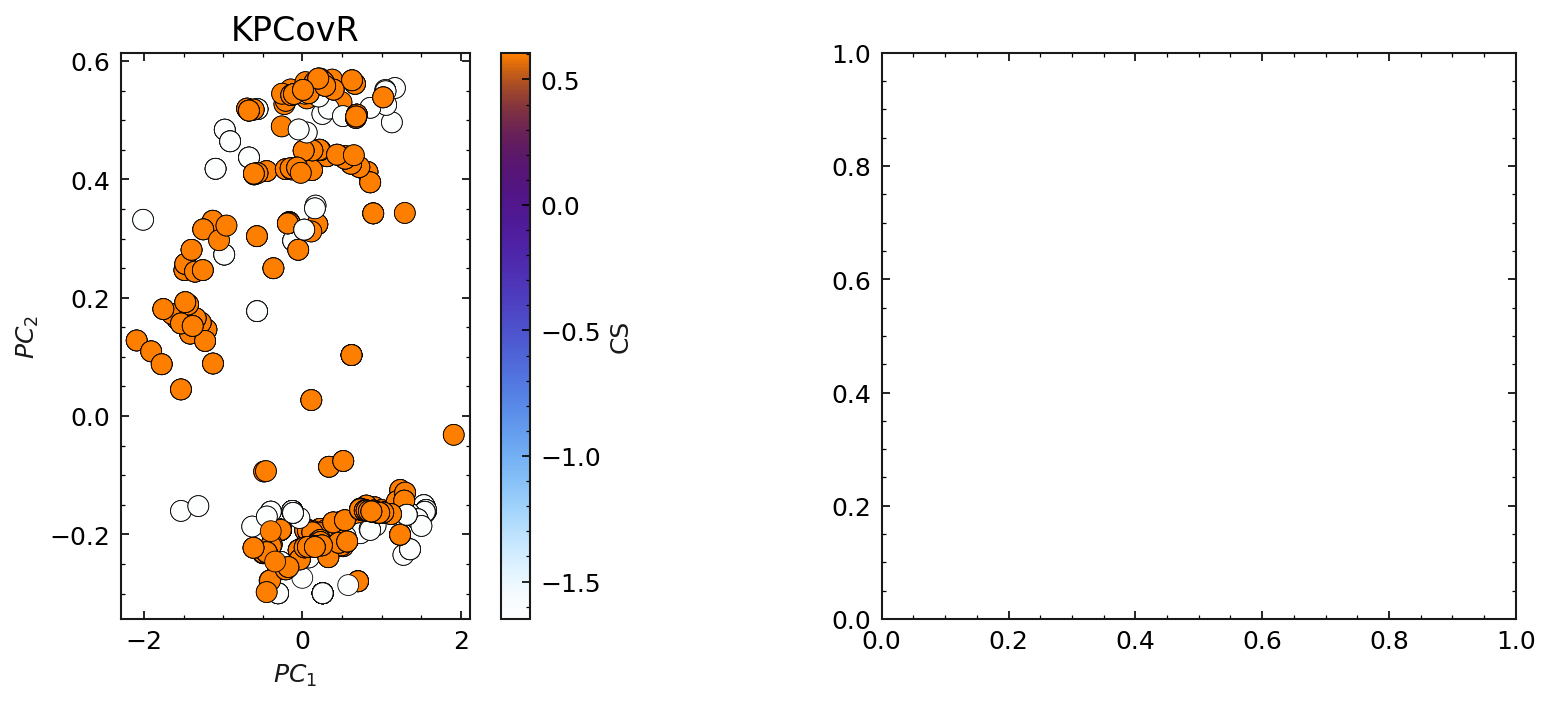

In [33]:
kp = KPCovR(mixing=0.5, n_components=2, **kernel_params, center=True, alpha=1E-4)
kp.fit(X_train, Y_train)
kp.fit(X_train, Y_train)
kp.alpha
t = kp.transform(X_test)
y = kp.predict(X_test)
fig, ax = plt.subplots(1, 2, figsize=dbl_fig)

plot_projection(Y_test, t, title="KPCovR", fig=fig, ax=ax[0], **cmaps)


In [ ]:
len(frames_ase[900:])

soap1 = SOAP(soap_type='PowerSpectrum',
           interaction_cutoff=3.5,
           max_radial=5,
           max_angular=5,
           gaussian_sigma_type='Constant',
           gaussian_sigma_constant=0.4,
           cutoff_smooth_width=0.5, 
           normalize=False)

soap_rep1 = soap1.transform(frames_ase[:100])
Xtot = soap_rep1.get_features(soap1)
print(Xtot.shape)
X_raw_pd=pd.DataFrame(Xtot)
X_raw_pd_drop=X_raw_pd.loc[:, (X_raw_pd != 0).any(axis=0)]
X_raw_red = X_raw_pd_drop.to_numpy()

print(str(Xtot.shape[1]-X_raw_red.shape[1])+ " columns dropped because they are all 0s.")
Xtot=X_raw_red
print(Xtot.shape)

col_idxs, col_dist = FPS(Xtot.T, n_FPS)
Xtot_FPS = Xtot[:, col_idxs]

x_scaler = StandardFlexibleScaler(column_wise=False).fit(Xtot_FPS)

# Center total dataset
Xtot = x_scaler.transform(Xtot_FPS)


(5728, 57450)


In [26]:
Xtot.shape, Xsparse.shape

((5110, 50), (2961, 50))

In [27]:

Knm = kernel_func(Xtot, Xsparse)

In [36]:
Knm.shape, Kmm.shape
print(Kmm)
from numpy.linalg import inv
i=inv(Kmm)
i

[[ 1.          1.          1.         ...,  0.27278739  0.23160871
   0.23160871]
 [ 1.          1.          1.         ...,  0.27278739  0.23160871
   0.23160871]
 [ 1.          1.          1.         ...,  0.27278739  0.23160871
   0.23160871]
 ..., 
 [ 0.27278739  0.27278739  0.27278739 ...,  1.          0.90832045
   0.90832045]
 [ 0.23160871  0.23160871  0.23160871 ...,  0.90832045  1.
   1.        ]
 [ 0.23160871  0.23160871  0.23160871 ...,  0.90832045  1.
   1.        ]]


LinAlgError: Singular matrix

In [41]:
kernel_matrix = Knm @ Kmm @ Knm.T

In [42]:
print(kernel_matrix)
# K_train = gaussian_kernel(X_train, X_train)
# K_test = gaussian_kernel(X_test, X_train)

k_scaler = KernelNormalizer().fit(kernel_matrix)

kernel_matrix = k_scaler.transform(kernel_matrix)

kernel_matrix

[[ 561932.21764282  561932.21764282  335047.41582182 ...,  339830.94863167
   340969.41081846  340969.41081846]
 [ 561932.21764282  561932.21764282  335047.41582182 ...,  339830.94863167
   340969.41081846  340969.41081846]
 [ 335047.41582182  335047.41582182  200277.4017429  ...,  202405.69939419
   203084.91012169  203084.91012169]
 ..., 
 [ 339830.94863167  339830.94863167  202405.69939419 ...,  208157.61698326
   208840.88430848  208840.88430848]
 [ 340969.41081846  340969.41081846  203084.91012169 ...,  208840.88430848
   209526.46846723  209526.46846723]
 [ 340969.41081846  340969.41081846  203084.91012169 ...,  208840.88430848
   209526.46846723  209526.46846723]]


array([[ 2.76264359,  2.76264359,  0.45495232, ...,  0.52565097,
         0.53716687,  0.53716687],
       [ 2.76264359,  2.76264359,  0.45495232, ...,  0.52565097,
         0.53716687,  0.53716687],
       [ 0.45495232,  0.45495232,  0.10528818, ...,  0.11954614,
         0.12130001,  0.12130001],
       ..., 
       [ 0.52565097,  0.52565097,  0.11954614, ...,  0.21082915,
         0.21266925,  0.21266925],
       [ 0.53716687,  0.53716687,  0.12130001, ...,  0.21266925,
         0.2145586 ,  0.2145586 ],
       [ 0.53716687,  0.53716687,  0.12130001, ...,  0.21266925,
         0.2145586 ,  0.2145586 ]])